# Capstone project - Evaluating San Francisco areas of COVID-19 risk

### 1. Introduction

The current pandemic of COVID-19 is not going away soon. In this project, I would like to use data sets to examine different neighborhoods in San Francisoco. 

San Francisco is one of the most populous city in the United States. The denser the city, the more easily disease can spread. Residents in larger cities definitely have to be more careful and engage in more intense social distancing. I will consider the **COVID-19 confirmed case numbers, population density, health care availability, as well as venue type** to identify the most risky areas in San Francisco. I hope this can be an easy guide for people to choose where to go for essential businesses, such as grocery shopping. This information might also be helpful to small business owners to make decisions about whether it is too risky to still continue non-essential business at this moment based on their locations.

### 2. Data

**DataSF.org** provides a lot of open data sets about San Francisco, while **FourSquare API** is resourceful of venue information. We will use the following data sources for this project: 
* The Rate_of_COVID-19_Cases_by_Census_ZIP_Code_Tabulation_Area.csv file from DataSF.org, which contains data updated as of 04/25/2020 about confirmed COVID-19 cases in different neighborhoods of San Francisco, as well as population in different areas; 
* The Health_Care_Facilities.csv file from DataSF.org, which summarizes all the health care facilities available in San Francisco;
* Information about venues in the region from the Four Square API. 

In this section, data will be downloaded, converted to data frames, and cleaned. Certain data will be converted to other relevant information, if needed.

#### COVID-19 case file

Let's load the COVID-19 case data into a dataframe and clean the data set. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
pip install geopy

     |████████████████████████████████| 112kB 6.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import geopy
from geopy.geocoders import Nominatim

In [4]:
covid19_0 = pd.read_csv('https://data.sfgov.org/api/views/favi-qct6/rows.csv?accessType=DOWNLOAD')
covid19_0.head()

,Data as of,OBJECTID,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,Count of San Francisco Confirmed Cases,Estimated 2017 ACS San Francisco Population,Estimated Rate of San Francisco Cases per 10k,Case Rate Difference from San Francisco,multipolygon
0,2020/04/28,2,94121,31.0,43638,7.10,5-10,1490,864263,17.24,-10.14,MULTIPOLYGON (((-122.48542599984555 37.7898249...
1,2020/04/28,4,94123,27.0,25461,10.60,10-15,1490,864263,17.24,-6.64,MULTIPOLYGON (((-122.45005999994794 37.8024729...
2,2020/04/28,13,94158,15.0,6547,22.91,20-25,1490,864263,17.24,5.67,MULTIPOLYGON (((-122.3836959998312 37.75470099...
3,2020/04/28,18,94107,102.0,29920,34.09,30-35,1490,864263,17.24,16.85,MULTIPOLYGON (((-122.38530302568738 37.7898378...
4,2020/04/28,1,94118,29.0,41417,7.00,5-10,1490,864263,17.24,-10.24,MULTIPOLYGON (((-122.44767900001601 37.7917029...


To simplify the dataframe, I will drop some columns which are not critical for the analysis.

In [5]:
covid19_1 = covid19_0.drop(columns=['Data as of', 'OBJECTID', 'Rate Groups',
                                    'Count of San Francisco Confirmed Cases',
                                   'Estimated 2017 ACS San Francisco Population',
                                    'Estimated Rate of San Francisco Cases per 10k',
                                    'Case Rate Difference from San Francisco', 'multipolygon'])
covid19_1.head(3)

,ZIP Code,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k
0,94121,31.0,43638,7.10
1,94123,27.0,25461,10.60
2,94158,15.0,6547,22.91


In [6]:
covid19_1.shape

(27, 4)

Get longitude and latitude from geocode based on the zip code in the data frame. Add latitude and longitude as two columns. This will help us later get the venue information for each area under a zip code.

In [7]:
Lat = []
Lon = []

for x in covid19_1['ZIP Code']:
    
    geolocator = Nominatim(user_agent="SF_explorer")
    location = geolocator.geocode(x)
    Lat.append(location.latitude)
    Lon.append(location.longitude)   

In [8]:
covid19_1.insert(1, 'Longitude', Lon)
covid19_1.insert(2, 'Latitude', Lat)
covid19_1.head(3)

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k
0,94121,-122.492289,37.778591,31.0,43638,7.10
1,94123,-122.430807,37.801901,27.0,25461,10.60
2,94158,-122.386635,37.770175,15.0,6547,22.91


Let's check if there is any missing data.

In [9]:
covid19_2 = covid19_1[covid19_1.isnull().any(axis=1)]
covid19_2

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k
11,94111,22.779728,58.292082,NaN,3356,NaN
15,94104,18.239498,48.136316,NaN,436,NaN
16,94108,-122.412280,37.792072,NaN,14856,NaN
24,94129,-122.466140,37.792799,NaN,4019,NaN
25,94130,13.606800,48.570202,NaN,3129,NaN


This means we don't miss any zip code, coordinates, or population. The NaN here means no confirmed cases for those reagions. So we will replace all NaN with 0s.

In [10]:
covid19_2 = covid19_1.fillna(0)
covid19_2.head()

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k
0,94121,-122.492289,37.778591,31.0,43638,7.10
1,94123,-122.430807,37.801901,27.0,25461,10.60
2,94158,-122.386635,37.770175,15.0,6547,22.91
3,94107,-122.392789,37.782740,102.0,29920,34.09
4,94118,-122.457818,37.775515,29.0,41417,7.00


In [11]:
covid19_2.shape

(27, 6)

In [12]:
covid19_2

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k
0,94121,-122.492289,37.778591,31.0,43638,7.10
1,94123,-122.430807,37.801901,27.0,25461,10.60
2,94158,-122.386635,37.770175,15.0,6547,22.91
3,94107,-122.392789,37.782740,102.0,29920,34.09
4,94118,-122.457818,37.775515,29.0,41417,7.00
5,94117,-122.451545,37.773044,38.0,43610,8.71
6,94116,-122.497991,37.741793,27.0,47708,5.66
7,94115,-122.440715,37.782586,95.0,35751,26.57
8,94109,-122.422591,37.798540,67.0,56587,11.84
9,94114,-122.435242,37.761403,34.0,34561,9.84


There are many wrong coordinated obtained from geocode. Shame! I will manually correct this by getting the coordinates from google map. 

In [13]:
covid19_2['Longitude'][11,12,15,18,25] = [-122.391282, -122.414547, -122.401883, -122.420426, -122.369931]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
covid19_2['Latitude'][11,12,15,18,25] = [37.397715, 37.749984, 37.791591, 37.778925, 37.821707]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
covid19_2

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k
0,94121,-122.492289,37.778591,31.0,43638,7.10
1,94123,-122.430807,37.801901,27.0,25461,10.60
2,94158,-122.386635,37.770175,15.0,6547,22.91
3,94107,-122.392789,37.782740,102.0,29920,34.09
4,94118,-122.457818,37.775515,29.0,41417,7.00
5,94117,-122.451545,37.773044,38.0,43610,8.71
6,94116,-122.497991,37.741793,27.0,47708,5.66
7,94115,-122.440715,37.782586,95.0,35751,26.57
8,94109,-122.422591,37.798540,67.0,56587,11.84
9,94114,-122.435242,37.761403,34.0,34561,9.84


#### Health care cacilities file

Now let's load the health care facilities file.

In [16]:
Health_0 = pd.read_csv('https://data.sfgov.org/api/views/jhsu-2pka/rows.csv?accessType=DOWNLOAD')
Health_0.head()

,UID,OSHPD_ID,Facility Name,Facility Type,Services,Location
0,2,106380933,California Pacific Med Ctr-davies Campus,General Acute Care Hospital,Hospital,POINT (-122.4358177 37.76905419)
1,42,306384163,On Lok Senior Health Services-mission Center,Community Clinic,Senior Health,POINT (-122.43329371 37.72674014)
2,20,306381276,"Drug Detoxification, Rehab And After Care Svs....",Free Clinic,Drug Treatment,POINT (-122.44870302 37.77029461)
3,48,306384201,St. Anthony Medical Clinic,Free Clinic,Free General Health,POINT (-122.41317234 37.78197735)
4,75,0,Special Programs For Youth,Community Health Network,,POINT (-122.45226708 37.74571703)


In [17]:
Health_0.shape

(78, 6)

Clean the data:

In [18]:
Health_1 = Health_0.drop(columns=['UID', 'OSHPD_ID', 'Facility Type'])
Health_1.head(3)

,Facility Name,Services,Location
0,California Pacific Med Ctr-davies Campus,Hospital,POINT (-122.4358177 37.76905419)
1,On Lok Senior Health Services-mission Center,Senior Health,POINT (-122.43329371 37.72674014)
2,"Drug Detoxification, Rehab And After Care Svs....",Drug Treatment,POINT (-122.44870302 37.77029461)


Convert the string in location 'POINT (-122.4358177 37.76905419)' to two float numbers

In [19]:
Health_2 = Health_1
Health_2[['Location']] = Health_1[['Location']].apply(lambda x: x.str.replace('POINT ',''))
Health_2[['Location']] = Health_1[['Location']].apply(lambda x: x.str.replace('(',''))
Health_2[['Location']] = Health_1[['Location']].apply(lambda x: x.str.replace(')',''))

In [20]:
Health_2['Location'] = Health_2['Location'].str.split()

In [21]:
Lon=[] # we create two lists for longitude and latitude
Lat=[]
for x in Health_2['Location']:
    Lon.append(float(x[0]))
    Lat.append(float(x[1]))

In [22]:
Health_2.insert(3, 'Longitude', Lon)
Health_2.insert(4, 'Latitude', Lat)

In [23]:
Health_3 = Health_2.drop('Location', axis=1)

As all the health care facilities only have coordinates information, but no zip code, we can use
the latitude and longitude data to get zip code for each facility by geopy

In [24]:
# define a function to conver to zip code
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.address.split(",")[-2]

In [25]:
geolocator = geopy.Nominatim(user_agent='San Francisco')

# use longitude and latitude data from Health_3 to get the zip codes
zipcodes = Health_3.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='Latitude', lon_field='Longitude')

In [26]:
zipcodes

0      94143
1      94112
2      94114
3      94102
4      94127
       ...  
73     94122
74     94109
75     94110
76     94121
77     94117
Length: 78, dtype: object

In [27]:
zipcodes.unique()

array([' 94143', ' 94112', ' 94114', ' 94102', ' 94127', ' 94118',
       ' 94131', ' 94103', ' 94116', ' 94113', ' ', ' 94124', ' 90103',
       ' 94158', ' 94133', ' 94134', ' 94110', ' 94109', ' 94188',
       ' 94108', ' 94104', ' 94115', ' 94131-3228', ' 94122', ' 94117',
       ' 94164', ' 94121'], dtype=object)

Notice that there is an NAN and one zip code with 9 digits. Also a zipcode shows 90103, which is not in the SF area. We need to correct these

In [28]:
p = np.where(zipcodes == ' 94131-3228') # find where in the np array is the 9-digit zip code
p

(array([42]),)

In [29]:
zipcodes[42] = ' 94131' # remove the last 4 digits

In [30]:
p = np.where(zipcodes == ' ') # find where in the np array is the NAN
p

(array([13]),)

Let's see which facility it is. We can manually find the zip code from google maps and add it. 

In [31]:
Health_3.iloc[13, ]

Facility Name    Housing And Urban Health Clinic
Services                                        
Longitude                               -122.412
Latitude                                 37.7841
Name: 13, dtype: object

In [32]:
zipcodes[13] = ' 94102' # 94102 was found from google map based on the facility name

In [33]:
p = np.where(zipcodes == ' 90103') # find where in the np array is the '90103', which is not a correct zip code in SF
p

(array([16]),)

In [34]:
Health_3.iloc[16, ]

Facility Name    Family Health Center At Sfgh
Services                                     
Longitude                            -122.407
Latitude                              37.7569
Name: 16, dtype: object

In [35]:
zipcodes[16] = ' 94110' # 94110 was found from google map based on the facility name

In [36]:
zipcodes.unique()

array([' 94143', ' 94112', ' 94114', ' 94102', ' 94127', ' 94118',
       ' 94131', ' 94103', ' 94116', ' 94113', ' 94124', ' 94110',
       ' 94158', ' 94133', ' 94134', ' 94109', ' 94188', ' 94108',
       ' 94104', ' 94115', ' 94122', ' 94117', ' 94164', ' 94121'],
      dtype=object)

In [37]:
codes = zipcodes.astype(int) # converting object to int, will match with other dataframes later
codes

0     94143
1     94112
2     94114
3     94102
4     94127
      ...  
73    94122
74    94109
75    94110
76    94121
77    94117
Length: 78, dtype: int64

Now the zipcodes array looks good. Let's insert zip codes to the dataframe

In [38]:
Health_3.insert(0, 'ZIP Code', codes)

In [39]:
Health_3.shape

(78, 5)

In [40]:
Health_3.head(3)

,ZIP Code,Facility Name,Services,Longitude,Latitude
0,94143,California Pacific Med Ctr-davies Campus,Hospital,-122.435818,37.769054
1,94112,On Lok Senior Health Services-mission Center,Senior Health,-122.433294,37.726740
2,94114,"Drug Detoxification, Rehab And After Care Svs....",Drug Treatment,-122.448703,37.770295


Let's examine the service types of these health care facilities. Not all of them are strongly relevant to fight against COVID-19, e.g. Drug Treatment in row 2. We will not include those before our analysis.  Also need to check if there is missing data.

In [41]:
Health_3['Services'].unique()

array(['Hospital', 'Senior Health', 'Drug Treatment',
       'Free General Health', ' ', 'Cultural General Health',
       'Sexual Health Clinic', 'General Health', 'Womens Health',
       'Family General Health', 'Mental Health', 'Youth Health'],
      dtype=object)

Remove facilities that are for Drug Treatment or Sexual Health Clinic.

In [42]:
Health_4 = Health_3[Health_3['Services'] != 'Drug Treatment']
Health_4 = Health_4[Health_4['Services'] != 'Sexual Health Clinic']
Health_4.head(3)

,ZIP Code,Facility Name,Services,Longitude,Latitude
0,94143,California Pacific Med Ctr-davies Campus,Hospital,-122.435818,37.769054
1,94112,On Lok Senior Health Services-mission Center,Senior Health,-122.433294,37.726740
3,94102,St. Anthony Medical Clinic,Free General Health,-122.413172,37.781977


In [43]:
Health_4.reset_index(drop=True, inplace=True)
Health_4.head()

,ZIP Code,Facility Name,Services,Longitude,Latitude
0,94143,California Pacific Med Ctr-davies Campus,Hospital,-122.435818,37.769054
1,94112,On Lok Senior Health Services-mission Center,Senior Health,-122.433294,37.726740
2,94102,St. Anthony Medical Clinic,Free General Health,-122.413172,37.781977
3,94127,Special Programs For Youth,,-122.452267,37.745717
4,94112,Mission Neighborhood Health Ctr.-excelsior Clinic,Cultural General Health,-122.433377,37.726682


In [44]:
Health_4.shape

(73, 5)

Find facilities with unassianged Services

In [45]:
x = np.where(Health_4['Services'] == ' ')
x

(array([ 3,  7,  8, 10, 11, 13, 15, 17, 21, 24, 25, 27, 28, 30, 36, 38, 40,
        47, 48, 56, 58, 62, 72]),)

In [46]:
Health_4['Services'][3, 7, 8, 10, 11, 13, 15, 17, 21, 24, 25, 27, 28, 30, 36, 38, 40,
        47, 48, 56, 58, 62, 72] = 'General-Unassigned'
Health_4.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,ZIP Code,Facility Name,Services,Longitude,Latitude
0,94143,California Pacific Med Ctr-davies Campus,Hospital,-122.435818,37.769054
1,94112,On Lok Senior Health Services-mission Center,Senior Health,-122.433294,37.726740
2,94102,St. Anthony Medical Clinic,Free General Health,-122.413172,37.781977
3,94127,Special Programs For Youth,General-Unassigned,-122.452267,37.745717
4,94112,Mission Neighborhood Health Ctr.-excelsior Clinic,Cultural General Health,-122.433377,37.726682


In [47]:
# Use groupby() to check how many facilities were found for each zip code
Health_5 = Health_4.groupby('ZIP Code').count()
Health_5.head()

,Facility Name,Services,Longitude,Latitude
ZIP Code,,,,
94102,9,9,9,9
94103,3,3,3,3
94104,1,1,1,1
94108,1,1,1,1
94109,4,4,4,4


In [48]:
# one hot encoding to get different types of services by these facilities
Health_onehot = pd.get_dummies(Health_4[['Services']], prefix="", prefix_sep="")
Health_onehot.head(3)

,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0


In [49]:
Health_onehot.shape

(73, 10)

In [50]:
# add zip code column to Health_onehot dataframe as the first column
Health_onehot.insert(0, 'ZIP Code', Health_4['ZIP Code'])
Health_onehot.head(3)

,ZIP Code,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health
0,94143,0,0,0,0,0,1,0,0,0,0
1,94112,0,0,0,0,0,0,0,1,0,0
2,94102,0,0,1,0,0,0,0,0,0,0


In [51]:
# let's group rows by zip code and take the count of occurrence of each category
Health_grouped = Health_onehot.groupby('ZIP Code').sum().reset_index()
Health_grouped.head()

,ZIP Code,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health
0,94102,1,0,1,0,5,0,0,1,1,0
1,94103,0,0,1,1,1,0,0,0,0,0
2,94104,0,0,0,1,0,0,0,0,0,0
3,94108,0,0,0,0,0,0,0,0,1,0
4,94109,0,1,0,0,1,1,0,1,0,0


Let's also add a column which shows the sum of all facilites for each zip code

In [52]:
# get all the columns except for 'ZIP Code'
columns = Health_grouped.columns
columns = columns[1:]
columns

Index(['Cultural General Health', 'Family General Health',
       'Free General Health', 'General Health', 'General-Unassigned',
       'Hospital', 'Mental Health', 'Senior Health', 'Womens Health',
       'Youth Health'],
      dtype='object')

In [53]:
summary = Health_grouped[columns].sum(axis =1)

In [54]:
Health_grouped.insert(1, 'Total Facilities', summary)

In [55]:
Health_grouped.head(3)

,ZIP Code,Total Facilities,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health
0,94102,9,1,0,1,0,5,0,0,1,1,0
1,94103,3,0,0,1,1,1,0,0,0,0,0
2,94104,1,0,0,0,1,0,0,0,0,0,0


In [56]:
Health_grouped.shape

(24, 12)

#### Four Square API for venue information

In [57]:
import numpy as np

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print('Libraries imported.')

Libraries imported.


First we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [58]:
# Define API credential
CLIENT_ID = 'S1KPK21EQRSXK5MGH5W3CLNRJAU0KO2NHHW2C3RISMQLZEZP' # your Foursquare ID
CLIENT_SECRET = '2KXEE03BBQSBTR20AIOOHIIYTNQBBKMR1KT0IKQFWDJD4N2P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [59]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

Let's create a function that extracts the category of the venue.

In [60]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a function to collect venues, sort, and get category type for all the neighborhoods in SF.

In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP Code', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We can run getNearbyVenues function now to get the data.

In [62]:
SF_venues = getNearbyVenues(names=covid19_2['ZIP Code'],
                                   latitudes=covid19_2['Latitude'],
                                   longitudes=covid19_2['Longitude'])

94121
94123
94158
94107
94118
94117
94116
94115
94109
94114
94112
94111
94110
94105
94103
94104
94108
94132
94102
94133
94134
94122
94124
94127
94129
94130
94131


In [63]:
print(SF_venues.shape)
SF_venues.head()

(2049, 7)


,ZIP Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,94121,37.778591,-122.492289,Pacific Cafe,37.779782,-122.494428,Seafood Restaurant
1,94121,37.778591,-122.492289,Kufu-ya Japanese Restaurant,37.779641,-122.494581,Japanese Restaurant
2,94121,37.778591,-122.492289,Pagan,37.781520,-122.493383,Burmese Restaurant
3,94121,37.778591,-122.492289,Cassava,37.775722,-122.496702,New American Restaurant
4,94121,37.778591,-122.492289,Jiangnan Cuisine,37.775890,-122.495616,Chinese Restaurant


Use groupby() to check how many venues were found for each zip code

In [64]:
SF_venues.groupby('ZIP Code').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZIP Code,,,,,,
94102,100,100,100,100,100,100
94103,100,100,100,100,100,100
94104,100,100,100,100,100,100
94105,100,100,100,100,100,100
94107,100,100,100,100,100,100


In [65]:
print('There are {} uniques categories.'.format(len(SF_venues['Venue Category'].unique())))

There are 288 uniques categories.


Explore each neighborhood/zip code

In [66]:
# one hot encoding
SF_onehot = pd.get_dummies(SF_venues[['Venue Category']], prefix="", prefix_sep="")
SF_onehot.head(3)

,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
SF_onehot.shape

(2049, 288)

In [68]:
# add neighborhood name column back to T_onehot dataframe as the first column
SF_onehot.insert(0, 'ZIP Code', SF_venues['ZIP Code'])

SF_onehot.head()

,ZIP Code,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo Exhibit
0,94121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,94121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,94121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,94121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94121,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by zip code and by taking the mean of the frequency of occurrence of each category

In [69]:
SF_grouped = SF_onehot.groupby('ZIP Code').mean().reset_index()
SF_grouped.head()

,ZIP Code,Acai House,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Yoga Studio,Zoo Exhibit
0,94102,0.00,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.00,...,0.01,0.00,0.00,0.00,0.05,0.00,0.0,0.0,0.01,0.0
1,94103,0.00,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.02,...,0.01,0.03,0.00,0.00,0.01,0.01,0.0,0.0,0.00,0.0
2,94104,0.01,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.01,...,0.00,0.00,0.00,0.01,0.02,0.01,0.0,0.0,0.01,0.0
3,94105,0.01,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.03,...,0.00,0.01,0.00,0.01,0.00,0.01,0.0,0.0,0.01,0.0
4,94107,0.00,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.02,...,0.00,0.01,0.01,0.00,0.02,0.01,0.0,0.0,0.01,0.0


In [70]:
SF_grouped.shape

(26, 289)

(This means there is one zip code that Four Square API did not find venues, as covid19_2.shape is (27,6)

Now let's create a new dataframe and display the top 10 venues for each zip code region

To achieve that, we need to define a function to sort the venues in descending order

In [71]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues] # only return the names not the freq.

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZIP Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZIP Code'] = SF_grouped['ZIP Code']

for ind in np.arange(SF_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SF_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,ZIP Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,Wine Bar,Theater,Coffee Shop,Beer Bar,Cocktail Bar,Clothing Store,Gym,Marijuana Dispensary,Ice Cream Shop,Thai Restaurant
1,94103,Coffee Shop,Gay Bar,Gym / Fitness Center,Marijuana Dispensary,Bakery,Vietnamese Restaurant,Dance Studio,Bar,Pizza Place,Sandwich Place
2,94104,Coffee Shop,Hotel,Food Truck,New American Restaurant,Gym / Fitness Center,Art Museum,Gym,Boutique,Mediterranean Restaurant,Sushi Restaurant
3,94105,Coffee Shop,Gym,Café,Gym / Fitness Center,Boutique,Museum,Spa,Burger Joint,Art Museum,Art Gallery
4,94107,Coffee Shop,Café,Gym,New American Restaurant,Baseball Stadium,Park,Gym / Fitness Center,Pizza Place,Art Museum,Bar


In [73]:
neighborhoods_venues_sorted.shape

(26, 11)

### 3. Methodology

I will start with area clustering using the K-Means method by comparing the top 10 common venue categories in each zip code region. A folium map will be created and show these different clusters with distinct colors. 

I will then look at all the combined data. The confirmed case distribution can be visualized in a bar graph and compare with population and other information. We will then check correlation of confirmed case rate per 10k with population and health care availability. It is also necessary to look for differences in the region clusters and see if the difference correlate with COVID-19 spread. 

Finally, I will assign a risk value to each region by giving certain weights to the contribution factors such as population, current confirmed case rate per 10k, health care facility rate per 10k, and cluster label. The regions can then be divided into four groups based on their risk values and visualized on a map.

### 4. Analysis/Results

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [75]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    pandas-1.0.3               |   py36h830a2c2_1        11.1 MB  conda-

#### Clustering the neighborhoods

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [76]:
# Run k-means to cluster the zip codes into 5 clusters.
# set number of clusters
kclusters = 5

SF_grouped_clustering = SF_grouped.drop('ZIP Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 3, 3, 3, 3], dtype=int32)

In [77]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Let's add zip code and coordinates to the dataframe

In [78]:
venues = covid19_2[['ZIP Code', 'Latitude', 'Longitude']]
venues = venues.join(neighborhoods_venues_sorted.set_index('ZIP Code'), on='ZIP Code')
venues_1 = venues.dropna() # there were two zip codes that didn't get venues from four square api. we drop those
venues_1.shape

(26, 14)

In [79]:
venues_1['Cluster Labels'] = venues_1['Cluster Labels'].astype(int)
venues_1.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ZIP Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94121,37.778591,-122.492289,3,Chinese Restaurant,Café,Playground,Vietnamese Restaurant,Bakery,Sushi Restaurant,Korean Restaurant,Japanese Restaurant,Thai Restaurant,Seafood Restaurant
1,94123,37.801901,-122.430807,3,Park,Italian Restaurant,Gym / Fitness Center,Wine Bar,French Restaurant,Spa,Vegetarian / Vegan Restaurant,Coffee Shop,Thai Restaurant,Yoga Studio
2,94158,37.770175,-122.386635,1,Park,Baseball Stadium,Coffee Shop,Gym,Soccer Field,Sports Bar,Restaurant,Basketball Stadium,Pizza Place,Lounge
3,94107,37.782740,-122.392789,1,Coffee Shop,Café,Gym,New American Restaurant,Baseball Stadium,Park,Gym / Fitness Center,Pizza Place,Art Museum,Bar
4,94118,37.775515,-122.457818,3,Park,Garden,Japanese Restaurant,Café,Coffee Shop,Vietnamese Restaurant,Board Shop,Bookstore,Sushi Restaurant,Gift Shop


Let visualize the clusters. Use geopy library to get the latitude and longitude values of San Francisco.

In [80]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="SF_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of SF are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of SF are 37.7790262, -122.4199061.


In [81]:
# create map of Toronto using latitude and longitude values
map_clusters = folium.Map(location=[37.7790262, -122.4199061], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [82]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_1['Latitude'], venues_1['Longitude'], venues_1['ZIP Code'], venues_1['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [83]:
Cluster_0 = venues_1[venues_1['Cluster Labels'] == 0]
Cluster_1 = venues_1[venues_1['Cluster Labels'] == 1]
Cluster_2 = venues_1[venues_1['Cluster Labels'] == 2]
Cluster_3 = venues_1[venues_1['Cluster Labels'] == 3]
Cluster_4 = venues_1[venues_1['Cluster Labels'] == 4]

print ('There are {} zip code groups in Cluster 0'.format(Cluster_0.shape[0]))
print ('There are {} zip code groups in Cluster 1'.format(Cluster_1.shape[0]))
print ('There are {} zip code groups in Cluster 2'.format(Cluster_2.shape[0]))
print ('There are {} zip code groups in Cluster 3'.format(Cluster_3.shape[0]))
print ('There are {} zip code groups in Cluster 4'.format(Cluster_4.shape[0]))

There are 1 zip code groups in Cluster 0
There are 7 zip code groups in Cluster 1
There are 3 zip code groups in Cluster 2
There are 14 zip code groups in Cluster 3
There are 1 zip code groups in Cluster 4


#### Combine data

Let's combine the useful data from covid19 and Health care facilities

In [84]:
merged_0 = covid19_2.join(Health_grouped.set_index('ZIP Code'), on='ZIP Code')

In [85]:
merged_0.head()

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Total Facilities,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health
0,94121,-122.492289,37.778591,31.0,43638,7.10,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,94123,-122.430807,37.801901,27.0,25461,10.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,94158,-122.386635,37.770175,15.0,6547,22.91,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,94107,-122.392789,37.782740,102.0,29920,34.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,94118,-122.457818,37.775515,29.0,41417,7.00,5.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0


In [86]:
merged_1 = merged_0.fillna(0) # several zip codes do not have health care facilities. Fill 0.
merged_1.head(3)

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Total Facilities,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health
0,94121,-122.492289,37.778591,31.0,43638,7.10,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,94123,-122.430807,37.801901,27.0,25461,10.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94158,-122.386635,37.770175,15.0,6547,22.91,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [87]:
merged_1.shape

(27, 17)

In [88]:
venues_2 = venues_1[['ZIP Code', 'Cluster Labels']]
merged_2 = merged_1.join(venues_2.set_index('ZIP Code'), on='ZIP Code')

In [89]:
Total_Facilities = merged_2['Total Facilities'].to_numpy()
population = merged_2['Estimated 2017 ACS Population']. to_numpy()
health_care_rate = Total_Facilities/population*10000
health_care_rate

array([ 0.22915807,  0.        ,  4.58225141,  0.        ,  1.20723374,
        0.68791562,  0.20960845,  1.39856228,  0.70687614,  0.28934348,
        0.46853221,  0.        ,  1.76302263,  0.        ,  1.11152279,
       22.93577982,  0.6731287 ,  0.        ,  2.98606503,  0.74233539,
        0.46431722,  0.47987715,  0.56350727,  0.47409093,  0.        ,
        0.        ,  0.68832599])

In [90]:
merged_2.insert(7, 'Health Care Facility rate per 10k', health_care_rate)

In [91]:
merged_2.head()

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Total Facilities,Health Care Facility rate per 10k,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health,Cluster Labels
0,94121,-122.492289,37.778591,31.0,43638,7.10,1.0,0.229158,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,94123,-122.430807,37.801901,27.0,25461,10.60,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,94158,-122.386635,37.770175,15.0,6547,22.91,3.0,4.582251,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0
3,94107,-122.392789,37.782740,102.0,29920,34.09,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,94118,-122.457818,37.775515,29.0,41417,7.00,5.0,1.207234,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,3.0


In [92]:
merged_2.sort_values(by=['ZIP Code'], ascending = True, inplace=True)
merged_2.reset_index(drop = True, inplace = True)
merged_2.head()

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Total Facilities,Health Care Facility rate per 10k,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health,Cluster Labels
0,94102,-122.420426,37.778925,71.0,30140,23.56,9.0,2.986065,1.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0
1,94103,-122.408251,37.775364,117.0,26990,43.35,3.0,1.111523,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,94104,-122.401883,37.791591,0.0,436,0.00,1.0,22.935780,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,94105,-122.397160,37.788566,15.0,7675,19.54,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,94107,-122.392789,37.782740,102.0,29920,34.09,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We are ready to visualize the data now! Let's first take a look at the confirmed cases

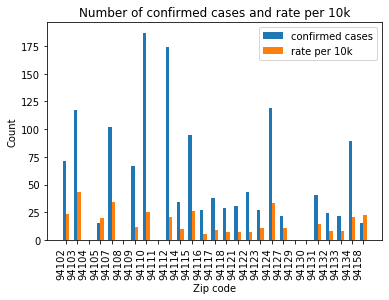

In [93]:
x = np.arange(merged_2.shape[0])  # the label locations
width = 0.3  # the width of the bars

plt.bar(x - width/2, merged_2['Count of Confirmed Cases'] , width, label='confirmed cases')
plt.bar(x + width/2, merged_2['Estimated Rate of Cases per 10k'], width, label='rate per 10k')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Count')
plt.title('Number of confirmed cases and rate per 10k')
plt.xticks(x, merged_2['ZIP Code'])
plt.xlabel("Zip code")
plt.legend()

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

The region with 94103 has the highest rate per 10k, thus might be more risky than the other regions. 

We can also take a look at the Total Facilities

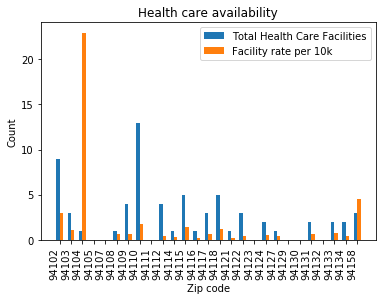

In [94]:
x = np.arange(merged_2.shape[0])  # the label locations
width = 0.3  # the width of the bars

plt.bar(x - width/2, merged_2['Total Facilities'] , width, label='Total Health Care Facilities')
plt.bar(x + width/2, merged_2['Health Care Facility rate per 10k'], width, label='Facility rate per 10k')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Count')
plt.title('Health care availability')
plt.xticks(x, merged_2['ZIP Code'])
plt.xlabel("Zip code")
plt.legend()

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

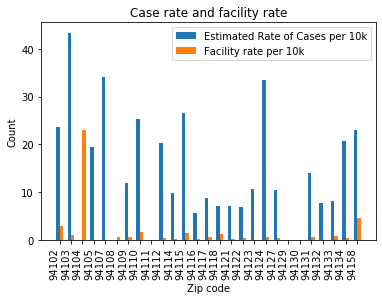

In [95]:
x = np.arange(merged_2.shape[0])  # the label locations
width = 0.3  # the width of the bars

plt.bar(x - width/2, merged_2['Estimated Rate of Cases per 10k'] , width, label='Estimated Rate of Cases per 10k')
plt.bar(x + width/2, merged_2['Health Care Facility rate per 10k'], width, label='Facility rate per 10k')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.ylabel('Count')
plt.title('Case rate and facility rate')
plt.xticks(x, merged_2['ZIP Code'])
plt.xlabel("Zip code")
plt.legend()

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

#### Correlation

Let's first see how strongly is confirmed case rate correlated with population.

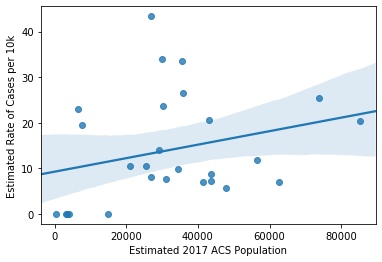

In [96]:
sns.regplot(x="Estimated 2017 ACS Population", y="Estimated Rate of Cases per 10k", data=merged_2)

In [97]:
merged_2[['Estimated 2017 ACS Population', 'Estimated Rate of Cases per 10k']].corr()

,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k
Estimated 2017 ACS Population,1.000000,0.272794
Estimated Rate of Cases per 10k,0.272794,1.000000


Looks like population is very weakly correlated. More populated areas have a higher case rate. How about health care availability then?

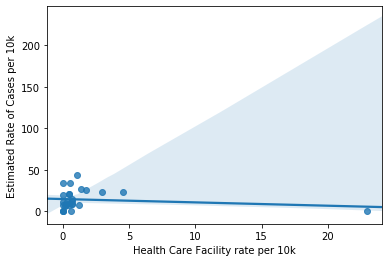

In [98]:
sns.regplot(x="Health Care Facility rate per 10k", y="Estimated Rate of Cases per 10k", data=merged_2)

In [99]:
merged_2[['Health Care Facility rate per 10k', 'Estimated Rate of Cases per 10k']].corr()

,Health Care Facility rate per 10k,Estimated Rate of Cases per 10k
Health Care Facility rate per 10k,1.000000,-0.150776
Estimated Rate of Cases per 10k,-0.150776,1.000000


There is a negative correlation as we expected, but very weak.

Now, let's see if the venue types play a role.

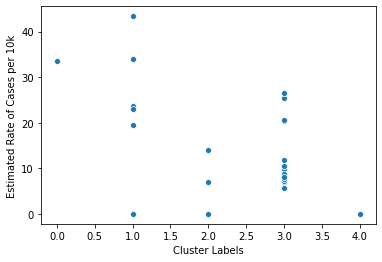

In [100]:
sns.scatterplot(x="Cluster Labels", y="Estimated Rate of Cases per 10k", data=merged_2)

Interesting! Looks like Cluster 2 and 4 have relative low confirmed case rates. Let's examine these two. Note that the cluster label numbers do not mean anything. 

In [117]:
Cluster_2

,ZIP Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,94122,37.753120,-122.467508,2,Trail,Chinese Restaurant,Bus Stop,Park,Dessert Shop,Bakery,Garden,Light Rail Station,Japanese Restaurant,Pharmacy
24,94129,37.792799,-122.466140,2,Trail,Golf Course,Park,Sushi Restaurant,Café,American Restaurant,Intersection,Art Gallery,Tennis Court,Bed & Breakfast
26,94131,37.750497,-122.451510,2,Trail,Scenic Lookout,Light Rail Station,Mountain,Tailor Shop,Sushi Restaurant,French Restaurant,Burrito Place,Monument / Landmark,Bus Stop


In [118]:
merged_2[merged_2['Cluster Labels'] == 2]

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Total Facilities,Health Care Facility rate per 10k,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health,Cluster Labels
16,94122,-122.467508,37.753120,43.0,62516,6.88,3.0,0.479877,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
20,94129,-122.466140,37.792799,0.0,4019,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
22,94131,-122.451510,37.750497,41.0,29056,14.11,2.0,0.688326,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0


Clearly, these regions have more open space than in-door venues in their top common categories, which can help reduce the infection rate. 

In [119]:
Cluster_4

,ZIP Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,94130,37.821707,-122.369931,4,Food Truck,Athletics & Sports,Music Venue,Baseball Field,Harbor / Marina,Rugby Pitch,Bus Station,Brewery,Breakfast Spot,Food Stand


In [120]:
merged_2[merged_2['Cluster Labels'] == 4]

,ZIP Code,Longitude,Latitude,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Total Facilities,Health Care Facility rate per 10k,Cultural General Health,Family General Health,Free General Health,General Health,General-Unassigned,Hospital,Mental Health,Senior Health,Womens Health,Youth Health,Cluster Labels
21,94130,-122.369931,37.821707,0.0,3129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


The region under zip code 94130 (Treasure Island and Yerba Buena Island) also has currently no confirmed COVID-19 case. Its population is small (~3k). Similar to regions in Cluster 1, this region has more open space than in-door venues, thus limiting the spread of the disease.

In [124]:
final = merged_2[['ZIP Code', 'Latitude', 'Longitude', 'Estimated 2017 ACS Population', 'Estimated Rate of Cases per 10k', 'Health Care Facility rate per 10k', 'Cluster Labels']]
final.head()

,ZIP Code,Latitude,Longitude,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Health Care Facility rate per 10k,Cluster Labels
0,94102,37.778925,-122.420426,30140,23.56,2.986065,1.0
1,94103,37.775364,-122.408251,26990,43.35,1.111523,1.0
2,94104,37.791591,-122.401883,436,0.00,22.935780,1.0
3,94105,37.788566,-122.397160,7675,19.54,0.000000,1.0
4,94107,37.782740,-122.392789,29920,34.09,0.000000,1.0


In [121]:
# assign different weights to cluster labels: 
c_labels = []
for x in final['Cluster Labels']:
    if x == 2 or x == 4:
        c_labels.append(1)
    else:
        c_labels.append(0)
np.asarray(c_labels)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0])

In [122]:
# assign weights to other factors
facility_rate = final['Health Care Facility rate per 10k'].to_numpy()
case_rate = final['Estimated Rate of Cases per 10k']. to_numpy()
pop = final['Estimated 2017 ACS Population']. to_numpy()

risk = pop/10000 + case_rate - facility_rate - c_labels
risk

array([ 23.58793497,  44.93747721, -22.89217982,  20.3075    ,
        37.082     ,   0.8124713 ,  16.79182386,  30.97067737,
         0.3356    ,  28.44876779,  13.00675652,  28.74653772,
        10.22119155,  12.38308438,   9.93446626,  11.23464193,
        11.65172285,  13.1461    ,  36.51569273,  12.06520907,
        -0.5981    ,  -0.6871    ,  15.32727401,  10.8155    ,
        10.12186461,  24.50308278,  18.98244859])

In [125]:
final.insert(1, 'Risk', risk)

In [126]:
final_1 = final.sort_values(by=['Risk'])

In [127]:
final_1.reset_index(drop=True, inplace=True)

In [134]:
final_1.tail()

,ZIP Code,Risk,Risk Group,Latitude,Longitude,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Health Care Facility rate per 10k,Cluster Labels
22,94115,28.746538,2,37.782586,-122.440715,35751,26.57,1.398562,3.0
23,94110,30.970677,3,37.749984,-122.414547,73737,25.36,1.763023,3.0
24,94124,36.515693,3,37.716300,-122.394562,35492,33.53,0.563507,0.0
25,94107,37.082000,3,37.782740,-122.392789,29920,34.09,0.000000,1.0
26,94103,44.937477,3,37.775364,-122.408251,26990,43.35,1.111523,1.0


Now, let's visualize the regions with risk on the map. I will set risk level to the follow four groups: <1, 9 to 20, 20 to 30, >30

In [129]:
group = []

for x in final_1['Risk']:
    if x < 1:
        group.append(0)
    if 9 < x < 20:
        group.append(1)
    if 20 < x < 30:
        group.append(2)
    if x > 30:
        group.append(3)
np.asarray(group)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 3, 3, 3, 3])

In [130]:
final_1.insert(2, 'Risk Group', group)

In [131]:
# create map of SF using latitude and longitude values
risk_map = folium.Map(location=[37.7790262, -122.4199061], zoom_start=12)

group_n=4 # total 4 groups
# set color scheme for the clusters
x = np.arange(group_n)
ys = [i + x + (i*x)**2 for i in range(group_n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [133]:
# add markers to the map
markers_colors = []
for lat, lon, poi, group in zip(final_1['Latitude'], final_1['Longitude'], final_1['ZIP Code'], final_1['Risk Group']):
    label = folium.Popup(str(poi) + ' Group ' + str(group), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[group-1],
        fill=True,
        fill_color=rainbow[group-1],
        fill_opacity=0.7).add_to(risk_map)
       
risk_map

### Discussions

The analysis showed that there was weak correlation of confirmed cases with population and also some extent to health care availability. As San Francisco is not a severe center of the pandemic, health care/hospital demands have not reached its full capacity yet, thus not showing a strong correlation. The case in New York City might be a completely different situation.

I also have to admit that this is a very simple model to assess areas in San Francisco for their risk of COVID-19 spread. In reality, more factors can come into play and contribute to the spread in opposite directions. For instance, in-door venues like supermarkets and open space such as parks have indeed very different weights in terms of disease spread, as infection can much easily occur in the former. But we currently only assigned a label and weight to the clusters, can did not really go into details.

Besides, at the very beginning of this pandemic when people were not well aware of its existence, people have much more in-person interactions with each other. But with the enforcement of social distancing and stay-at-home orders, those interactions have been significantly reduced. Many venues such as cinemas and bars have been also forced to close, which has further limited the spread. Thus, sectioning the number of confirmed cases based on dates might help render a better illustration of the real situation. In the future, we can take those into account and improve the model for evaluation. 

### Conclusions

In summary, we have evaluated different areas in San Francisco during the current COVID-19 pandemic. We found that confirmed COVID-19 case numbers are related to population, the type of neighborhood cluster in terms of venue categories, and very weakly to health care facility rate per population. Region clustering were performed by using the K-Means method and showed that regions with more open space venues have lower COVID-19 case rate per 10k.   

The purpose of this project is to identify regions with higher risk of disease spread so that people could avoid these areas for their essential business, if necessary. The results suggested the region with zip code 94103 has the highest risk. In the near future, when the situation improves, policy makers could also use the results to consider opening business area by area, from the safest to the most risky ones. 